<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%8C%8C%EB%A8%B8%EC%99%84_ch3_1~5_pg_147~174.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 평가
* 분류의 성능 평가 지표
  * 정확도
  * 오차행렬
  * 정밀도
  * F1스코어
  * ROC AUC

* 1. 정확도 : 실제데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

  * 정확도=예측 결과가 동일한 데이터 건수/전체 예측 데이터 건수 


In [1]:
# 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지지 않고 성별에 따라 생존자를 예측하는 단순한 classifier 생성 

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음.
  def fit( self, X, y=None):
    pass
  #predict() 메서드는 단순히 Sex 피쳐가 1이면 0, 그렇지 않으면 1로 예측
  def predict(self, X):
    pred=np.zeros((X.shape[0],1))
    for i in range( X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else: pred[i]=1

    return pred

In [6]:
# 앞선 장에서 만들어놓은 전처리함수 
from sklearn.preprocessing import LabelEncoder
#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할 
titanic_df =pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=0)

# 위에서 생성한 DummyClassifier를 이용해 학습/예측/평가 수행 
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [8]:
#MNIST 데이터 세트를 변환해 불균형한 데이터 세트에 정확도 지표 적용시 어떤 문제?

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

#불균형한 데이터 세트와 Dummy classifier 생성 

class MyFakeClassifier(BaseEstimator):
  def fit(Self,X,y):
    pass

  #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST데이터 로딩
digits=load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test=train_test_split(digits.data, y, random_state=11)

In [9]:

#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{: .3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


* 2. 오차행렬: 학습된 분류모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 보여줌

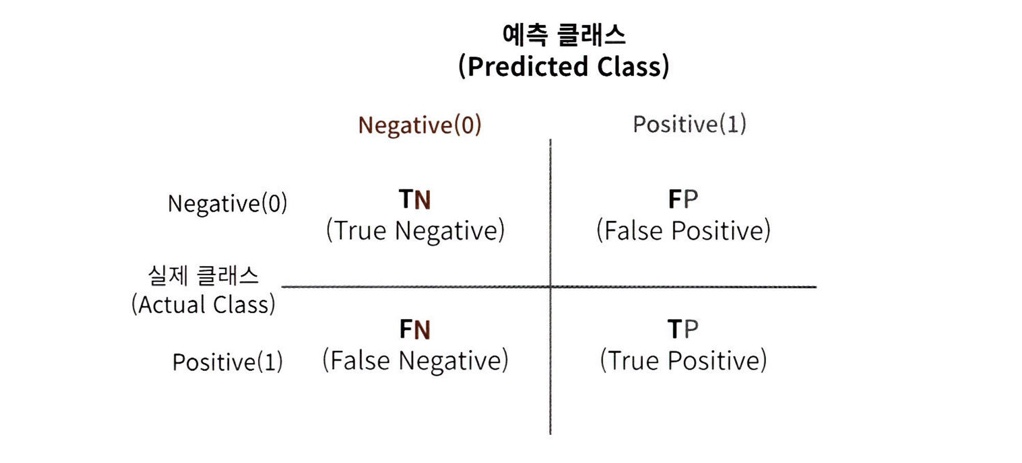

* TN: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
* FP: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
* FN: 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
* TP: 예측값을 Positvie 값 1로 예측했고 실제 값 역시 Positive 값 1

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,fakepred)
# 오차 행렬과 동일한 위치

array([[405,   0],
       [ 45,   0]])

* 정확도=(TN+TP)/(TN+FP+FN+TP)
* 불균형한 이진 분류 데이터 세트에서는 positive 건수가 매우 작아 데이터에 기반한 ML알고리즘은 Negative로 예측 정확도가 높아지는 경향이 발생
* 정확도는 분류 모델의 성능을 측정할 수 있는 한가지 요소일 뿐.

* 3. 정밀도와 재현율: positive 데이터 세트의 에측 성능에 좀 더 초점을 맞춘 평가지표

* 정밀도=TP/(FP+TP)
* 재현율=TP/(FN+TP)
* 재현율이 중요 지표인 경우: 실제 양성 데이터를 음성으로 잘못판단하게 되면 업무상 큰 영향이 발생하는 경우 (ex.암 판단 모델, 보험 사기)
* 정밀도가 중요 지표인 경우 : 실제 음성 데이터를 양성으로 잘못 판단 X 경우우

In [11]:
#get_clf_eval(): 오차행렬, 정확도, 정밀도, 재현율 등의 평가 한번에 호출출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 분할.
titanic_df=pd.read_csv('train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test= train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

#정밀도>재현율

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 정밀도/재현율 트레이드 오프
* 임곗값을 조정해 정밀도, 재현율 수치 변경 가능 (반드시 하나가 높아지면 다른 하나의 수치는 떨어짐)
* 예측 확률이 큰 레이블값으로 예측
* 이진 분류에서는 임곗값이 0.5로 이보다 크면 Positive, 작으면 Negative로 결정

In [13]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba( ) 의 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba( ) 의 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


In [14]:
# 넘파이 ndarray 입력
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [16]:

# Binarizer threshold임곗값을 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
#재현율이 올라가고 정밀도가 떨어진다. 

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [17]:

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

#재현율 향상시키면서 다른 수치 감소, 0.45 적당당

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [18]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shpae:', thresholds.shape)

# 반환된 임곗값 로우가 143건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

# 임곗값이 증가할수록 정밀도는 증가하고, 재현율은 감소소

반환된 분류 결정 임곗값 배열의 Shpae: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


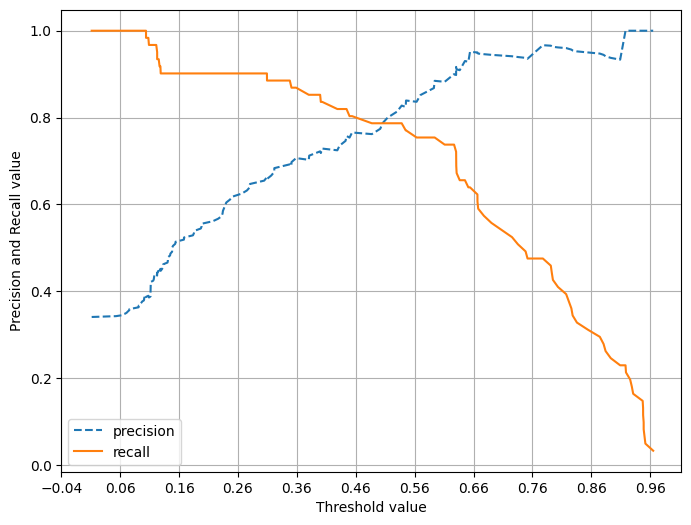

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0,1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

# 정밀도와 재현율의 맹점
* 정밀도가 100% 되는 방법 : 확실한 기준이 되는 경우=P ,나머지는 모두=N 으로 예측 
* 재현율이 100 : 모든 환자=P


* 4.F1스코어: 정밀도와 재현율을 결합한 지표
  * 정밀도와 재현율이 어느 한쪽으로 치우치지않는 수치를 나타낼 때 상대적으로 높은 값을 가짐짐

In [20]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [21]:
# 임곗값을 변화시키면서 F1스코어를 포함한 평가 지표를 구해보기기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

# 임곗값이 0.6일때 가장 좋지만, 재현율은 크게 감소하므로 주의 

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


* 5.ROC곡선(수신자 판단 곡선)과 AUC :이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표
  * ROC곡선(수신자 판단 곡선):FPR이 변할 때, TPR(재현율)이 어떻게 변하는지를 나타냄 
  * 민감도(TPR): 실제값 Postive(양성)가 정확히 예측되어야 하는 수준(질병 있는 사람은 질병이 있는 것으로 양성 판정)

  * 특이성(TNR): 실제값 Negative(음성)가 정확히 예측되어야 하는 수준(질병 없는 사람은 질병 없는 것으로 음성 판정)

In [24]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))
     

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


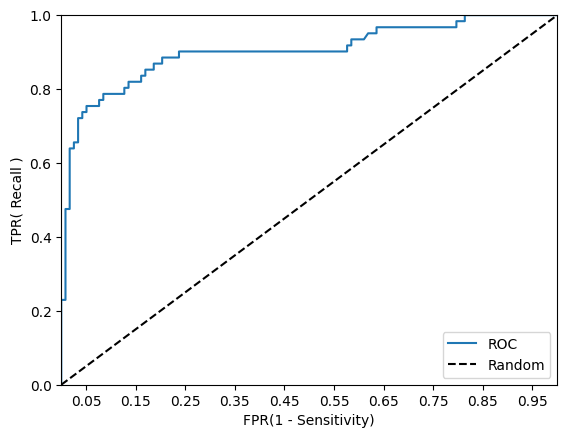

In [25]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])  

# 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR 커짐

In [27]:

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

'''
print(confusion_matrix(y_target, preds))
print("정확도:", np.round(accuracy_score(y_target, preds), 4))
print("정밀도:", np.round(precision_score(y_target, preds), 4))
print("재현율:", np.round(recall_score(y_target, preds), 4))
'''


'\nprint(confusion_matrix(y_target, preds))\nprint("정확도:", np.round(accuracy_score(y_target, preds), 4))\nprint("정밀도:", np.round(precision_score(y_target, preds), 4))\nprint("재현율:", np.round(recall_score(y_target, preds), 4))\n'

In [28]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))